<a href="https://colab.research.google.com/github/valerialrc/ufv/blob/main/ELT575_Semana3_89397.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Habilitar Google Drive no Colab
from google.colab import drive
drive.mount('/content/drive')

from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

Mounted at /content/drive


# Importando dados

Nesse problema de predição, usaremos um dataset contido em um arquivo csv. Assim, usamos a função read_csv do pandas passando a PATH no Google Drive como caminho dos dados.
* Usaremos os últimos 20% dos pontos temporais como dados de teste

* Uma transformação Min-Max é usada apenas para colocar os dados numa escala [0,1]

In [2]:
def get_train_test(path, split_percent=0.8):
    df = read_csv(path, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

path = '/content/drive/MyDrive/UFV/ELT575/tesla_stock_2015_2022.csv'
train_data, test_data, data = get_train_test(path)

# Preparação dos dados

Para preparar os dados para a rede recorrente, devemos quebrar a série temporal em vetores de tamanho igual ao número de entradas da nossa rede (estamos considerando assim quantos time steps passados estamos usando para prever o time step atual)

In [3]:
len(train_data)

1315

In [4]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Construindo o modelo

Usaramos aqui uma rede recorrente simples com 3 unidades ocultas que utilizam 12 passos anteriores para estimar o atual estado. O resultado é avaliado por um único neurônio totalmente conectado que nos dá a saída da rede
* Função de ativação tanh em ambas as camadas da rede.

* Como função objetiva, usaremos o erro médio quadrático, já que estamos lidando com um problema de predição

In [5]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 3s - loss: 0.0018 - val_loss: 0.0032 - 3s/epoch - 29ms/step
Epoch 2/20
109/109 - 0s - loss: 1.5432e-04 - val_loss: 0.0034 - 497ms/epoch - 5ms/step
Epoch 3/20
109/109 - 1s - loss: 7.6171e-05 - val_loss: 0.0051 - 579ms/epoch - 5ms/step
Epoch 4/20
109/109 - 0s - loss: 8.2617e-05 - val_loss: 0.0080 - 431ms/epoch - 4ms/step
Epoch 5/20
109/109 - 1s - loss: 1.3258e-04 - val_loss: 0.0032 - 502ms/epoch - 5ms/step
Epoch 6/20
109/109 - 1s - loss: 6.6191e-05 - val_loss: 0.0059 - 563ms/epoch - 5ms/step
Epoch 7/20
109/109 - 1s - loss: 2.2077e-04 - val_loss: 0.0043 - 730ms/epoch - 7ms/step
Epoch 8/20
109/109 - 1s - loss: 8.5563e-05 - val_loss: 0.0085 - 676ms/epoch - 6ms/step
Epoch 9/20
109/109 - 1s - loss: 1.1882e-04 - val_loss: 0.0069 - 747ms/epoch - 7ms/step
Epoch 10/20
109/109 - 1s - loss: 6.0752e-05 - val_loss: 0.0033 - 698ms/epoch - 6ms/step
Epoch 11/20
109/109 - 1s - loss: 8.7569e-05 - val_loss: 0.0042 - 742ms/epoch - 7ms/step
Epoch 12/20
109/109 - 1s - loss: 7.7902e-05 - v

## Avaliando o treinamento

Primeiro avaliamos o erro médio quadrático do conjunto de treino e de teste

In [6]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 22ms/step
Raíz do Erro Médio Quadrático para Treino: 0.011
Raíz do Erro Médio Quadrático para Teste: 0.061


Podemos também plotar como as nossas previsões se comparam com a série temporal original, como mostrado abaixo

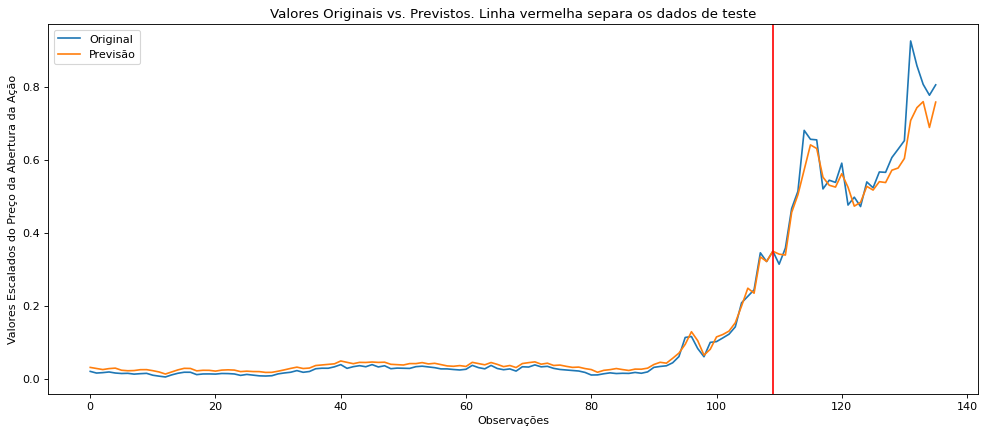

In [7]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Original', 'Previsão'])
    plt.xlabel('Observações')
    plt.ylabel('Valores Escalados do Preço da Abertura da Ação')
    plt.title('Valores Originais vs. Previstos. Linha vermelha separa os dados de teste')
plot_result(trainY, testY, train_predict, test_predict)

# Adicionando mais uma camada LSTM após a primeira
Mesmo número de unidades ocultas do item anterior.

In [8]:
def create_RNN_double_LSTM(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=True))
    model.add(LSTM(hidden_units, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 3s - loss: 6.0823e-04 - val_loss: 0.0030 - 3s/epoch - 27ms/step
Epoch 2/20
109/109 - 1s - loss: 1.3689e-04 - val_loss: 0.0090 - 748ms/epoch - 7ms/step
Epoch 3/20
109/109 - 1s - loss: 1.1241e-04 - val_loss: 0.0029 - 658ms/epoch - 6ms/step
Epoch 4/20
109/109 - 1s - loss: 6.2228e-05 - val_loss: 0.0027 - 761ms/epoch - 7ms/step
Epoch 5/20
109/109 - 1s - loss: 6.1710e-05 - val_loss: 0.0028 - 770ms/epoch - 7ms/step
Epoch 6/20
109/109 - 1s - loss: 5.4827e-05 - val_loss: 0.0042 - 810ms/epoch - 7ms/step
Epoch 7/20
109/109 - 1s - loss: 1.5229e-04 - val_loss: 0.0038 - 737ms/epoch - 7ms/step
Epoch 8/20
109/109 - 1s - loss: 2.4741e-04 - val_loss: 0.0029 - 537ms/epoch - 5ms/step
Epoch 9/20
109/109 - 0s - loss: 5.2032e-05 - val_loss: 0.0027 - 480ms/epoch - 4ms/step
Epoch 10/20
109/109 - 1s - loss: 3.8435e-05 - val_loss: 0.0071 - 535ms/epoch - 5ms/step
Epoch 11/20
109/109 - 1s - loss: 1.0257e-04 - val_loss: 0.0022 - 504ms/epoch - 5ms/step
Epoch 12/20
109/109 - 1s - loss: 3.8577e-05

In [9]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 23ms/step
Raíz do Erro Médio Quadrático para Treino: 0.007
Raíz do Erro Médio Quadrático para Teste: 0.067


A Raíz do Erro Médio Quadrático para Treino diminuiu levemente, o que pode significar que o modelo está se ajustando melhor aos dados de treinamento, mas como a Raíz do Erro Médio Quadrático para Teste aumentou, o modelo pode estar com um leve overfitting.

# Adicionando um Dropout de 20% após cada camada LSTM

In [10]:
def create_RNN_double_LSTM_and_dropout(hidden_units, dense_units, input_shape, activation, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(hidden_units, activation=activation[0]))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 3s - loss: 0.0017 - val_loss: 0.0072 - 3s/epoch - 27ms/step
Epoch 2/20
109/109 - 1s - loss: 1.1873e-04 - val_loss: 0.0045 - 678ms/epoch - 6ms/step
Epoch 3/20
109/109 - 1s - loss: 8.4999e-05 - val_loss: 0.0068 - 666ms/epoch - 6ms/step
Epoch 4/20
109/109 - 1s - loss: 3.8261e-04 - val_loss: 0.0038 - 740ms/epoch - 7ms/step
Epoch 5/20
109/109 - 1s - loss: 1.1962e-04 - val_loss: 0.0051 - 731ms/epoch - 7ms/step
Epoch 6/20
109/109 - 1s - loss: 9.9091e-05 - val_loss: 0.0038 - 719ms/epoch - 7ms/step
Epoch 7/20
109/109 - 1s - loss: 8.3054e-05 - val_loss: 0.0042 - 601ms/epoch - 6ms/step
Epoch 8/20
109/109 - 0s - loss: 6.0896e-05 - val_loss: 0.0033 - 480ms/epoch - 4ms/step
Epoch 9/20
109/109 - 0s - loss: 5.5045e-05 - val_loss: 0.0089 - 467ms/epoch - 4ms/step
Epoch 10/20
109/109 - 0s - loss: 1.6861e-04 - val_loss: 0.0191 - 485ms/epoch - 4ms/step
Epoch 11/20
109/109 - 0s - loss: 1.8534e-04 - val_loss: 0.0059 - 434ms/epoch - 4ms/step
Epoch 12/20
109/109 - 0s - loss: 5.0191e-05 - v

In [11]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 25ms/step
Raíz do Erro Médio Quadrático para Treino: 0.007
Raíz do Erro Médio Quadrático para Teste: 0.053


O resultado indica que a adição das camadas de dropout ajudou a diminuir o overfitting do modelo.

# Modificando o modelo para que ele tenha 4 blocos LSTM (50 unidades ocultas) + Dropout (20 %) antes da camada Dense.

In [12]:
def create_RNN_quadruple_LSTM_and_dropout(hidden_units, dense_units, input_shape, activation, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0], return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(hidden_units, activation=activation[0], return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(hidden_units, activation=activation[0], return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(hidden_units, activation=activation[0]))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

Epoch 1/20
109/109 - 3s - loss: 7.3600e-04 - val_loss: 0.0081 - 3s/epoch - 25ms/step
Epoch 2/20
109/109 - 0s - loss: 9.4301e-05 - val_loss: 0.0034 - 465ms/epoch - 4ms/step
Epoch 3/20
109/109 - 1s - loss: 8.3465e-05 - val_loss: 0.0040 - 520ms/epoch - 5ms/step
Epoch 4/20
109/109 - 0s - loss: 8.3512e-05 - val_loss: 0.0058 - 465ms/epoch - 4ms/step
Epoch 5/20
109/109 - 1s - loss: 7.9801e-05 - val_loss: 0.0034 - 510ms/epoch - 5ms/step
Epoch 6/20
109/109 - 0s - loss: 9.7913e-05 - val_loss: 0.0032 - 485ms/epoch - 4ms/step
Epoch 7/20
109/109 - 1s - loss: 1.0586e-04 - val_loss: 0.0036 - 506ms/epoch - 5ms/step
Epoch 8/20
109/109 - 0s - loss: 1.7282e-04 - val_loss: 0.0123 - 483ms/epoch - 4ms/step
Epoch 9/20
109/109 - 1s - loss: 8.9988e-05 - val_loss: 0.0051 - 578ms/epoch - 5ms/step
Epoch 10/20
109/109 - 1s - loss: 7.8650e-05 - val_loss: 0.0027 - 675ms/epoch - 6ms/step
Epoch 11/20
109/109 - 1s - loss: 1.0973e-04 - val_loss: 0.0044 - 732ms/epoch - 7ms/step
Epoch 12/20
109/109 - 1s - loss: 1.6096e-04

In [13]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 [==============================] - 0s 38ms/step
Raíz do Erro Médio Quadrático para Treino: 0.006
Raíz do Erro Médio Quadrático para Teste: 0.049


Como a Raíz do Erro Médio Quadrático para Teste continuou a diminuir e para Treino se manteve sem grande alterações, presume-se que o modelo se adaptou melhor aos dados do que com apenas o tratamento inicial. Pode-se continuar a adicionar camadas de LSTM com dropout e verificar se o resultado continua melhorando.